# Urban mobility in São Paulo during COVID-19 crisis

Population adherence to quarantine is a leading factor to flatten COVID's infection curve. SPTrans shares daily bus statistics that can be used as a proxy to adherence in São Paulo - for NYC we used subway turnstile data ([see it here](https://nbviewer.jupyter.org/github/gustal/portfolio/blob/master/NYC%20Daily%20Subway%20Data/NYC%20Daily%20Subway%20Data.ipynb)).

### Libraries

In [1]:
# =============================================================================
# Importing libraries
# =============================================================================

# Data handling
import numpy as np
import pandas as pd

# Data visualization
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import matplotlib as mpl

plt.style.use('fivethirtyeight') # Setting default visualization

# Date parser
from datetime import datetime as dt
from dateutil.relativedelta import relativedelta
from datetime import date, datetime
import dateutil.parser

# Others
import os
import html.parser
import urllib.request
from IPython.display import HTML

# Alignment: center
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

### Loading files

In [10]:
# =============================================================================
# Loading files
# =============================================================================

rdates = pd.date_range(start = '01/01/2018', end = '12/31/2020', freq = 'd') # Date range

# Loading file
tb = pd.read_excel(r'D:\Projetos\portfolio\SPtrans\sptrans.xlsx', parse_date = 'date')


tb = tb.pivot_table(index = tb.date.dt.year, columns = [tb.date.dt.month, tb.date.dt.day], values = 'total_passengers')\
        .pct_change().reset_index().melt(id_vars = 'date')\
        .dropna()\
        .assign(date = lambda x: (x.date.astype(str) + '-' +  x.variable_0.astype(str) + '-' + x.variable_1.astype(str)).apply(dt.strptime, args = ('%Y-%m-%d',)))\
        .merge(pd.DataFrame({'date':rdates}), on = 'date', how = 'outer')\
        .drop(['variable_0', 'variable_1'], axis = 1)\
        .rename(columns = {'value':'pc_change_yoy'})\
        .sort_values('date')

# Reshaping data
total = pd.read_excel(r'D:\Projetos\portfolio\SPtrans\sptrans.xlsx', parse_date = 'date')\
          .filter(['date', 'pc_change_yoy'])\
          .dropna()\
          .merge(pd.DataFrame({'date':rdates}), on = 'date', how = 'outer')\
          .sort_values('date')

### Chart

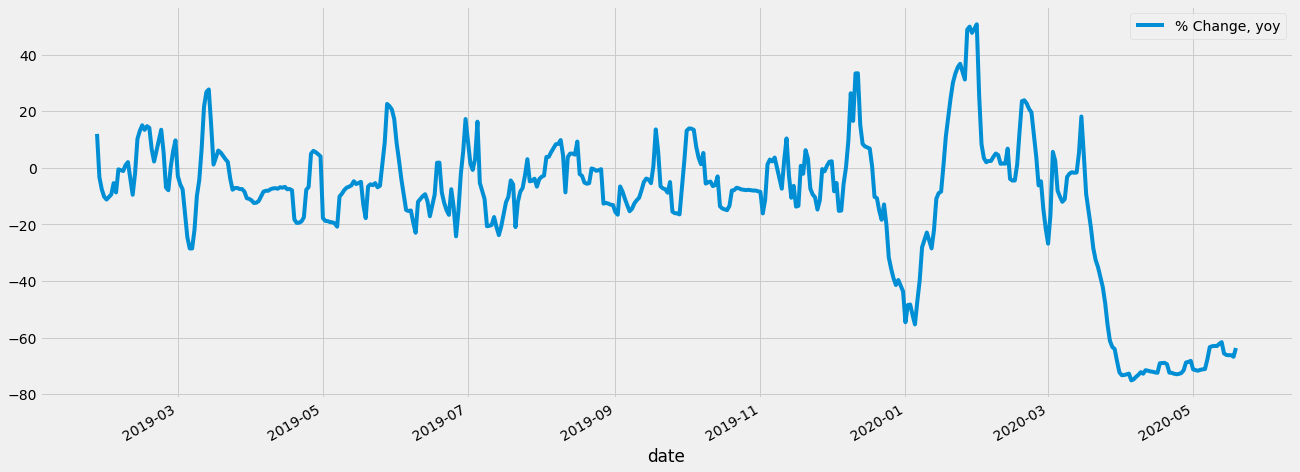

In [11]:
# =============================================================================
# Line chart
# =============================================================================

fig, ax = plt.subplots(1, 1, figsize = (20, 8))
(total.set_index('date') * 100)\
    .rename(columns = {'pc_change_yoy': '% Change, yoy'})\
    .dropna().plot(ax = ax)

### Heatmap

C:\Users\gusta\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:75: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


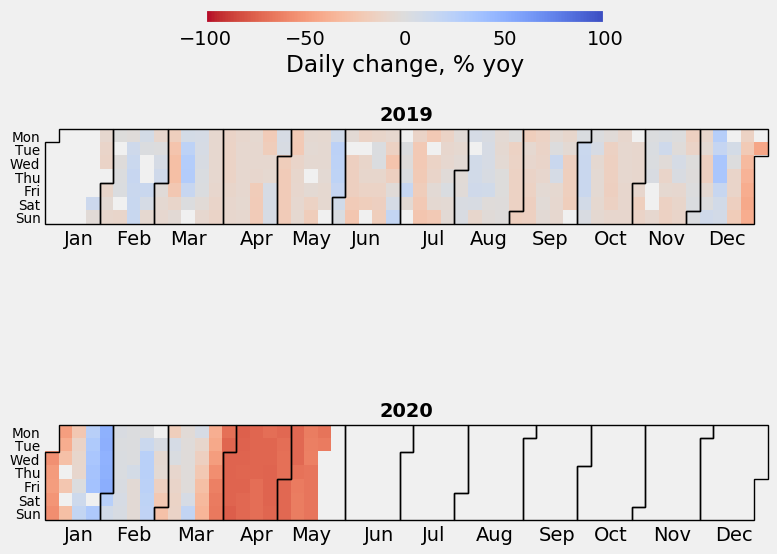

In [12]:
# =============================================================================
# Plotting calendar
# =============================================================================

# Calendar function
def calmap(ax, year, data, origin="upper", weekstart="sun"):
    ax.tick_params('x', length=0, labelsize="medium", which='major')
    ax.tick_params('y', length=0, labelsize="x-small", which='major')

    # Month borders
    xticks, labels = [], []

    start = datetime(year, 1, 1).weekday()

    _data = np.zeros(7 * 53) * np.nan
    _data[start:start + len(data)] = data
    data = _data.reshape(53, 7).T

    for month in range(1, 13):
        first = datetime(year, month, 1)
        last = first + relativedelta(months=1, days=-1)
        if origin == "lower":
            y0 = first.weekday()
            y1 = last.weekday()
            x0 = (int(first.strftime("%j")) + start - 1) // 7
            x1 = (int(last.strftime("%j")) + start - 1) // 7
            P = [(x0, y0), (x0, 7), (x1, 7), (x1, y1 + 1),
                 (x1 + 1, y1 + 1), (x1 + 1, 0), (x0 + 1, 0), (x0 + 1, y0)]
        else:
            y0 = 6 - first.weekday()
            y1 = 6 - last.weekday()
            x0 = (int(first.strftime("%j")) + start - 1) // 7
            x1 = (int(last.strftime("%j")) + start - 1) // 7
            P = [(x0, y0 + 1), (x0, 0), (x1, 0), (x1, y1),
                 (x1 + 1, y1), (x1 + 1, 7), (x0 + 1, 7), (x0 + 1, y0 + 1)]

        xticks.append(x0 + (x1 - x0 + 1) / 2)
        labels.append(first.strftime("%b"))
        poly = Polygon(P, edgecolor="black", facecolor="None",
                       linewidth=1, zorder=20, clip_on=False)
        ax.add_artist(poly)

    ax.set_xticks(xticks)
    ax.set_xticklabels(labels)
    ax.set_yticks(0.5 + np.arange(7))

    labels = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
    if origin == "upper": labels = labels[::-1]
    ax.set_yticklabels(labels)
    ax.set_title("{}".format(year), size="medium", weight="bold")

    # Showing data
    cmap = plt.cm.get_cmap('coolwarm_r')
    ax.imshow(data, extent=[0, 53, 0, 7], zorder=10,
              vmin=-1, vmax=1, cmap=cmap, origin=origin)

# Plotting figure
fig = plt.figure(figsize=(8, 7.5), dpi=100)

year = 2019 # Starting year
n = 2
for i in range(n):
    ax = plt.subplot(n, 1, i + 1, xlim=[0, 53], ylim=[0, 7], frameon=False, aspect=1)
    calmap(ax, year + i, (total.query(f'date.dt.year == {year + i}').pc_change_yoy.values), origin="upper")
    ax.grid(False) # Hide grids

# Color bar
cmap = plt.cm.get_cmap('coolwarm_r')
norm = mpl.colors.Normalize(vmin=-100, vmax=100)

cax = fig.add_axes([0.27, 0.9, 0.5, 0.02]) # Color bar needs it's own axes (https://stackoverflow.com/questions/32462881/add-colorbar-to-existing-axis)
fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), cax=cax, orientation='horizontal', label='Daily change, % yoy')

# Saving figure
plt.tight_layout()
plt.savefig(r"auxiliar\sptrans.svg", dpi=300, transparent = True, format = 'svg')
plt.show()